# Detect Aircraft in Satellite Imagery
## Stage 2: Model Optimization and Testing


### Data Import

In [36]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import random
from sklearn import metrics, feature_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, adadelta, adam

%matplotlib inline
sns.set_style('white')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [64]:
with open('./planesnet/planesnet.json', mode='r') as file:
    planesdict = json.load(file)
df = pd.DataFrame(planesdict)
df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


### Feature Assessment with PCA
***

In order to optimize, fit, and test the learning algorithms, the dimensionality of the feature space (i.e., 1200 pixel intensity values per image) must be reduced before processing, due limited time and compute resources. 

Principal component analysis (PCA) is performed to assess the explained variance of 1200 principal components (PCs). Prior to PCA, the data is scaled ― mean centering and unit variance. 

The explained variance of each principal component is displayed on the graph below. We can see that the first PC accounts for the largest variance in the set of 1200. A logarithmic scale is applied to the y-axis for better visualization of the features with lower explained variance.

From the display below, it appears that the slope of the explained variance stabilizes around 120 PCs. In addition, 99% of the total explained variance is accounted for by the first 120 PCs. Therefore, 120 is the number of PCs chosen for input into predictive modeling.

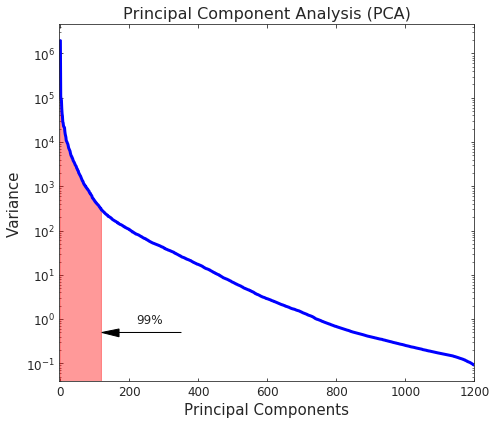

First 120 PCs account for 99.11% of explained variance.


In [60]:
#independent and dependent variables
X = []
for img in df.data:
    img = np.array(img)
    X.append(img)

X = np.array(X).astype('float64')
y = np.array(df['labels']).astype('float64')

#PCA
Xscaled = scale(X)
pca = PCA()
pca.fit(X)

#plot variables
a = list(range(0, 120))
b = pca.explained_variance_[0:120]
prc = (np.sum((pca.explained_variance_[:120]))) / np.sum(pca.explained_variance_) * 100
features = range(pca.n_components_)

#plot PCA feature variance
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(features, pca.explained_variance_, linewidth=3, color='blue')
ax.set_yscale('log')
ax.set_ylabel('Variance')
ax.set_xlabel('Principal Components')
ax.set_xlim(-5, 1200)
ax.fill_between(a, b, color='red', alpha=0.4)
ax.arrow(350, 0.5, -180, 0, color='k', head_width=0.2, head_length=50)
ax.text(x=220, y=.8, s=('{0:.0f}%'.format(prc)), fontsize=12)
ax.set_title('Principal Component Analysis (PCA)', size=16)
plt.xticks()
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/PCA.png')
plt.tight_layout()
plt.show()

print('First 120 PCs account for {0:.2f}% of explained variance.'.format(prc))

### Machine Learning Optimization
*** 
Before optimization, the data are split into train and test datasets ― 80% for training and 20% for testing. The test dataset is set aside for model evaluation.

The data are scaled and PCA is performed to reduce the number of features to 120. Algorithm parameters are optimized on the training dataset, the best training accuracy scores are printed out after each model is optimized over the chosen parameter set.

In [4]:
#split train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)

#scale for input to machine learning
Xscaled = scale(Xtrain)
Xscaled_test = scale(Xtest)

#PCA with chosen number of components
pca = PCA(n_components=120)
X_pca = pca.fit_transform(Xscaled)
X_pca_test = pca.fit_transform(Xscaled_test)

#### Logistic Regression Classifier (LRC)
***
* The inverse of regularization strength (i.e., C) is tested over a range of values from 0.001 to 100. 

* Various solvers including 'newton-cg', 'liblinear', and 'sag' are tested.

* The penalty is set to the default of L2. The three solvers support L2 penalty, with multi_class set to 'ovr'.

In [5]:
#parameters to test
cs = [0.001, 0.01, 0.1, 1.0, 10, 100]
solvers = ['newton-cg', 'liblinear', 'sag']

#gridsearchcv
parameters = {'solver':solvers, 'C':cs}
lrc = LogisticRegression(multi_class='ovr', max_iter=1000)
grd_lrc = GridSearchCV(lrc, param_grid=parameters, cv=5, return_train_score=True)
grd_lrc.fit(X_pca, ytrain)

print('Best parameters:', grd_lrc.best_params_)
print('Best score:', grd_lrc.best_score_)

Best parameters: {'C': 10, 'solver': 'newton-cg'}
Best score: 0.9073046875


#### K Neighbors Classifier (KNN)
***
* The number of neighbors (i.e., n_neighbors) is tested over a range of values from 1 to 34.

* The magnitude, or weight, of each neighbor's vote (i.e., weights) is tested on 'uniform', and 'distance'. The former treats every neighbor's vote as equal in the prediction process, while the latter assigns a weight to each neighbor's vote based on the neighbor's distance from the query point.

In [6]:
#parameters to test
n_neighbors = list(range(1,35))
weights = ['uniform', 'distance']

#gridsearchcv
parameters = {'n_neighbors':n_neighbors, 'weights':weights}
knn = KNeighborsClassifier()
grd_knn = GridSearchCV(knn, param_grid=parameters, cv=5, return_train_score=True)
grd_knn.fit(X_pca, ytrain)

print('Best parameters:', grd_knn.best_params_)
print('Best score:', grd_knn.best_score_)

Best parameters: {'n_neighbors': 2, 'weights': 'uniform'}
Best score: 0.95640625


#### Random Forest Classifier (RFC)
*** 
* The number of trees in the forest (i.e., n_estimators) is tested over a range of values from 10 to 1000. 

* The minimum number of samples required to split an internal node (i.e., min_samples_split) is tested on values from 2 to 4. 

* The maximum number of features to consider when looking for the best split (i.e., max_features) is set to the square root of the total number of features.

In [8]:
#parameters to test
n_estimators = [10, 100, 300, 700, 1000]
min_samples_split = [2, 3, 4]

#gridsearchcv
parameters = {'n_estimators':n_estimators, 'min_samples_split':min_samples_split}
rfc = RandomForestClassifier(random_state=0, max_features='sqrt')
grd_rfc = GridSearchCV(rfc, param_grid=parameters, cv=5, return_train_score=True)
grd_rfc.fit(X_pca, ytrain)

print('Best parameters:', grd_rfc.best_params_)
print('Best score:', grd_rfc.best_score_)

Best parameters: {'min_samples_split': 4, 'n_estimators': 700}
Best score: 0.9368359375


#### AdaBoost Classifier (ADA)
***
* The number of trees in the forest (i.e., n_estimators) is tested over a range of values from 10 to 1000. 

* The learning rate or shrinkage (i.e., learning_rate) is tested over a range of values from 0.001 to 10.0.

In [9]:
#parameters to test
n_estimators = [10, 100, 300, 700, 1000]
learning_rate = [0.001, 0.01, 0.1, 1.0, 10.0]

#gridsearchcv
parameters = {'n_estimators':n_estimators, 'learning_rate':learning_rate}
ada = AdaBoostClassifier(random_state=0)
grd_ada = GridSearchCV(ada, param_grid=parameters, cv=5, return_train_score=True)
grd_ada.fit(X_pca, ytrain)

print('Best parameters:', grd_ada.best_params_)
print('Best score:', grd_ada.best_score_)

Best parameters: {'learning_rate': 1.0, 'n_estimators': 1000}
Best score: 0.934375


#### Gradient Boosting Classifier (GBC)
***
* The number of trees in the forest (i.e., n_estimators) is tested over a range of values from 10 to 1000. 

* The learning rate or shrinkage (i.e., learning_rate) is tested over a range of values from 0.001 to 10.0. 

* The minimum number of samples required to split an internal node (i.e., min_samples_split) is tested on values from 2 to 4. 

* The maximum number of features to consider when looking for the best split (i.e., max_features) is set to the square root of the total number of features.

* The loss function (i.e., loss) is set to 'deviance', as recommended in the scikit-learn documentation for classification problems.

In [10]:
#parameters to test
n_estimators = [10, 100, 300, 700, 1000]
learning_rate = [0.001, 0.01, 0.1, 1.0, 10.0]
min_samples_split = [2, 3, 4]

#gridsearchcv
parameters = {'n_estimators':n_estimators, 'learning_rate':learning_rate, 'min_samples_split':min_samples_split}
gbc = GradientBoostingClassifier(random_state=0, loss='deviance', max_features='sqrt')
grd_gbc = GridSearchCV(gbc, param_grid=parameters, cv=5, return_train_score=True)
grd_gbc.fit(X_pca, ytrain)

print('Best parameters:', grd_gbc.best_params_)
print('Best score:', grd_gbc.best_score_)

Best parameters: {'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 1000}
Best score: 0.96140625


#### GridSearchCV Results
***
The display below suggests a rather tight range of accuracy scores for LRC, KNN, and RFC. However, both ADA and GBC have significantly low-accuracy outliers, with scores below 0.45 and 0.26 respectively. The low-accuracy outliers in both ADA and GBC correspond to test runs with the learning rate (i.e., learning_rate) set to  10.0.

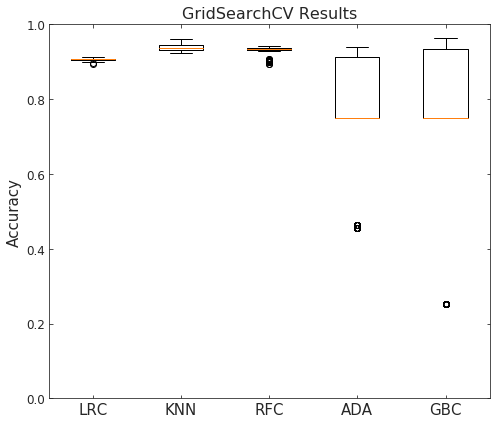

In [35]:
#gridsearhcv results
gscv_models = {'LRC': grd_lrc, 'KNN': grd_knn, 'RFC': grd_rfc, 'ADA': grd_ada, 'GBC': grd_gbc}
results = []
names = []
for model in gscv_models:
    res = pd.DataFrame(gscv_models[model].cv_results_)
    res.to_json('/home/delloro/Springboard/Assignments/Capstone_2/test_results/{}_GScv_results.json'.format(model))
    res = res.loc[:, ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].values.ravel()
    results.append(res)
    names.append(model)

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(results)
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('GridSearchCV Results', size=16)
plt.xticks(range(1, len(names)+1), names, size=15)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/GridSearchCV_ML.png')

plt.tight_layout()
plt.show()

#### Model Fit and Classification Report
***

Each of the five machine learning algorithms are fit ― using the best parameters from the GridSearchCV ― to the training dataset, and tested with the test dataset. Classification reports for each of the five models are printed out below. In general, the model performance is mediocre at best. This could be due to poor feature selection, or inappropriate model selection for image classification. Better results might be obtained by using higher quality/resolution images (e.g., in terms of pixel count), or by using different image features such as Canny edges or band distribution features. 

In [12]:
#fit models with best parameters to training dataset
fit_models = {'LRC':'LRC', 'KNN':'KNN', 'RFC':'RFC', 'ADA':'ADA', 'GBC':'GBC'}
for model in fit_models:
    fit_models[model] = gscv_models[model].best_estimator_
    fit_models[model].fit(X_pca, ytrain)

#print fit models' classification reports
target_names = ['Not-Plane', 'Plane']
accuracy = {}
ypreds = {}
pred_probs = {}
for model in fit_models:
    pred_probs[model] = fit_models[model].predict_proba(X_pca_test)
    ypred = fit_models[model].predict(X_pca_test)
    ypreds[model] = ypred
    print(model, '\n')
    print('Classification Report')
    print(metrics.classification_report(ytest, ypred, target_names=target_names))
    acc = metrics.accuracy_score(ytest, ypred)
    accuracy[model] = acc
    print('Accuracy:', acc)
    print('-----------------------------------------------------------', '\n')

LRC 

Classification Report
              precision    recall  f1-score   support

   Not-Plane       0.76      0.78      0.77      4831
       Plane       0.26      0.24      0.25      1569

   micro avg       0.64      0.64      0.64      6400
   macro avg       0.51      0.51      0.51      6400
weighted avg       0.64      0.64      0.64      6400

Accuracy: 0.64484375
----------------------------------------------------------- 

KNN 

Classification Report
              precision    recall  f1-score   support

   Not-Plane       0.77      0.91      0.83      4831
       Plane       0.36      0.16      0.22      1569

   micro avg       0.72      0.72      0.72      6400
   macro avg       0.56      0.53      0.53      6400
weighted avg       0.67      0.72      0.68      6400

Accuracy: 0.72484375
----------------------------------------------------------- 

RFC 

Classification Report
              precision    recall  f1-score   support

   Not-Plane       0.76      0.95      0.

### Convolutional Neural Network (CNN) Training

#### 1D Convolutional Neural Network (1D CNN)
***
A CNN is trained using a feature set with reduced dimensionality (i.e., 120 PCs). The 120 PCs are shaped into 120x1 arrays, and split into train, test, and validation datasets.

First, the full dataset is split into train and test datasets ― 80% for training and 20% for testing. The test dataset is set aside for model evaluation. Then the train dataset is split to separate a validation dataset for training, 10% of the train dataset is used for validation.

Four 1D convolutional layers are used to build a sequential model, each with batch normalization and a relu activation function. Padding is used in each convolutional layer to maintain spatial size and preserve information on the edges as the data is processed through the network. The adadelta optimizer is used with an initial learning rate (i.e., lr) of 1.0, an exponentially weighted average decay factor (i.e., rho) set to 0.95, and a learning rate decay (i.e., decay) of 0.0. The output layer is a single node with a sigmoid activation function for binary classification.

In [20]:
#independent and dependent variables
X = []
for img in df.data:
    img = np.array(img)
    X.append(img)

X = np.array(X)
y = np.array(df['labels'])

#PCA dimension reduction
pca = PCA(n_components=120)
X_pca = pca.fit_transform(X)

#reshape PCA data for input to CNN
X = []
for data in X_pca:
    X.append(data.reshape((120, 1)))

X = np.array(X)

#split 1st for test, 2nd for validation
Xtemp, Xtest, ytemp, ytest = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
Xtrain, X_valid, ytrain, y_valid = train_test_split(Xtemp, ytemp, test_size=0.10, shuffle=True, random_state=0)

In [21]:
#1D CNN parameters
shape = (120, 1)
kernel_size = 2
stride = 1
optimizer = adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

#1D CNN
model_1D = Sequential()

model_1D.add(Conv1D(16, kernel_size=kernel_size, strides=stride, padding='same', data_format='channels_last', input_shape=shape))
model_1D.add(BatchNormalization())
model_1D.add(Activation('relu'))

model_1D.add(Conv1D(32, kernel_size=kernel_size, strides=stride, padding='same'))
model_1D.add(BatchNormalization())
model_1D.add(Activation('relu'))

model_1D.add(Conv1D(64, kernel_size=kernel_size, strides=stride, padding='same'))
model_1D.add(BatchNormalization())
model_1D.add(Activation('relu'))

model_1D.add(Conv1D(64, kernel_size=kernel_size, strides=stride, padding='same'))
model_1D.add(BatchNormalization())
model_1D.add(Activation('relu'))

model_1D.add(Flatten())
model_1D.add(Dense(1, activation='sigmoid'))

model_1D.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
print(model_1D.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 120, 16)           48        
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 16)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 120, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 32)           1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 32)           128       
_________________________________________________________________
activation_2 (Activation)    (None, 120, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 120, 64)           4160      
__________

In [22]:
es = EarlyStopping(patience=4)
model_1D_log = model_1D.fit(Xtrain, ytrain, validation_data=(X_valid, y_valid), epochs=30, callbacks=[es])

Train on 23040 samples, validate on 2560 samples
Epoch 1/30
23040/23040 [==============================] - 40s 2ms/step - loss: 0.1845 - binary_accuracy: 0.9285 - val_loss: 0.1304 - val_binary_accuracy: 0.9531
Epoch 2/30
23040/23040 [==============================] - 38s 2ms/step - loss: 0.1335 - binary_accuracy: 0.9505 - val_loss: 0.1206 - val_binary_accuracy: 0.9574
Epoch 3/30
23040/23040 [==============================] - 38s 2ms/step - loss: 0.1154 - binary_accuracy: 0.9565 - val_loss: 0.1196 - val_binary_accuracy: 0.9609
Epoch 4/30
23040/23040 [==============================] - 38s 2ms/step - loss: 0.1003 - binary_accuracy: 0.9626 - val_loss: 0.1042 - val_binary_accuracy: 0.9660
Epoch 5/30
23040/23040 [==============================] - 38s 2ms/step - loss: 0.0901 - binary_accuracy: 0.9678 - val_loss: 0.0997 - val_binary_accuracy: 0.9688
Epoch 6/30
23040/23040 [==============================] - 39s 2ms/step - loss: 0.0802 - binary_accuracy: 0.9693 - val_loss: 0.1247 - val_binary_ac

In [24]:
#classification report
pred_probs['1D CNN'] = model_1D.predict(Xtest)
ypreds['1D CNN'] = model_1D.predict(Xtest)
ypreds['1D CNN'] = np.where(ypreds['1D CNN'] > 0.5, 1, 0)
ypreds['1D CNN'] = np.asarray(ypreds['1D CNN'], dtype=bool)
target_names = ['Not-Plane', 'Plane']
print('1D CNN \n')
print('Classification Report')
print(metrics.classification_report(ytest, ypreds['1D CNN'], target_names=target_names))
acc = metrics.accuracy_score(ytest, ypreds['1D CNN'])
accuracy['1D CNN'] = acc
print('Accuracy:', acc)

1D CNN 

Classification Report
              precision    recall  f1-score   support

   Not-Plane       0.97      0.98      0.97      4831
       Plane       0.93      0.90      0.92      1569

   micro avg       0.96      0.96      0.96      6400
   macro avg       0.95      0.94      0.95      6400
weighted avg       0.96      0.96      0.96      6400

Accuracy: 0.95984375


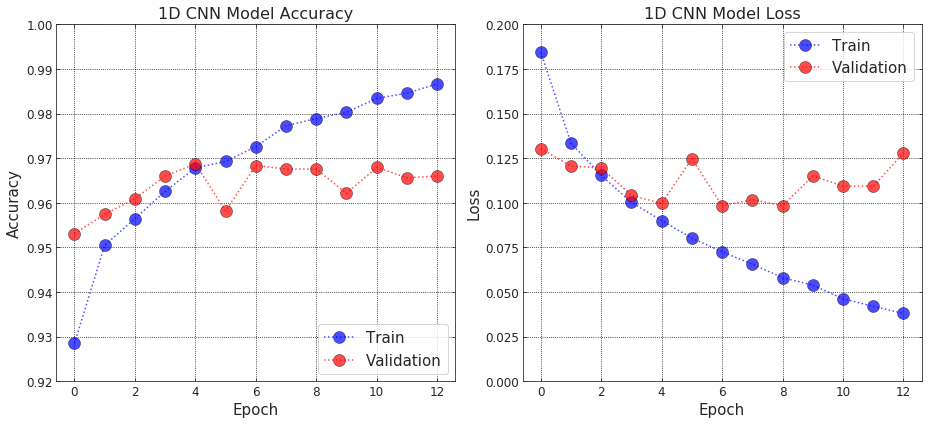

In [32]:
#model accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].plot(model_1D_log.history['binary_accuracy'], marker='o', color='blue', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[0].plot(model_1D_log.history['val_binary_accuracy'], marker='o', color='red', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.92, 1)
ax[0].grid(b=True, which='both', axis='both', color='k', linestyle=':')
ax[0].legend(['Train', 'Validation'], loc='lower right', prop={'size':15}, facecolor='white')
ax[0].set_title('1D CNN Model Accuracy', size=16)

ax[1].plot(model_1D_log.history['loss'], marker='o', color='blue', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[1].plot(model_1D_log.history['val_loss'], marker='o', color='red', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.0, 0.2)
ax[1].grid(b=True, which='both', axis='both', color='k', linestyle=':')
ax[1].legend(['Train', 'Validation'], loc='upper right', prop={'size':15}, facecolor='white')
ax[1].set_title('1D CNN Model Loss', size=16)

plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/1D_CNN_accloss.png')
plt.tight_layout()
plt.show()

#### 2D Convolutional Neural Network (2D CNN)
***
A CNN is trained using the full feature set available (i.e., 1200 pixel intensities), as opposed to using a feature set with reduced dimensionality (i.e., 120 PCs). The 1200 features are shaped into 20x20x3 arrays, and split into train, test, and validation datasets.

First, the full dataset is split into train and test datasets ― 80% for training and 20% for testing. The test dataset is set aside for model evaluation. Then the train dataset is split to separate a validation dataset for training, 10% of the train dataset is used for validation.

Five 2D convolutional layers are used to build a sequential model, each with batch normalization and a relu activation function. Max pooling is added after the fourth 2D convolutional layer. Padding is used in each convolutional layer to maintain spatial size and preserve information as the data is processed through the network. 

The adadelta optimizer is used with an initial learning rate (i.e., lr) of 0.1, an exponentially weighted average decay factor (i.e., rho) set to 0.95, and a learning rate decay (i.e., decay) of 0.00001. The optimizer used in the 2D CNN is parameterized differently than the optimizer in the 1D CNN, that is because the adjustment offered better results for the 2D CNN, while the adjustment did not significantly improve results of the 1D CNN.

Again, the output layer is a single node with a sigmoid activation function for binary classification.  

In [26]:
#reshape data for input to 2D CNN
X = []
for img in df.data:
    img = np.array(img)
    X.append(img.reshape((3, 400)).T.reshape(20, 20, 3))

X = np.array(X)
y = np.array(df['labels'])

#split 1st for test, 2nd for validation
Xtemp, Xtest, ytemp, ytest = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
Xtrain, X_valid, ytrain, y_valid = train_test_split(Xtemp, ytemp, test_size=0.10, shuffle=True, random_state=0)

In [27]:
#2D CNN parameters
shape = (20, 20, 3)
kernel_size = 3
stride = 1
optimizer = adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.00001)

#2D CNN
model_2D = Sequential()

model_2D.add(Conv2D(16, kernel_size=kernel_size, strides=stride, padding='same', data_format='channels_last', input_shape=shape))
model_2D.add(BatchNormalization())
model_2D.add(Activation('relu'))

model_2D.add(Conv2D(32, kernel_size=kernel_size, strides=stride, padding='same'))
model_2D.add(BatchNormalization())
model_2D.add(Activation('relu'))

model_2D.add(Conv2D(64, kernel_size=kernel_size, strides=stride, padding='same'))
model_2D.add(BatchNormalization())
model_2D.add(Activation('relu'))

model_2D.add(Conv2D(64, kernel_size=kernel_size, strides=stride, padding='same'))
model_2D.add(BatchNormalization())
model_2D.add(Activation('relu'))
model_2D.add(MaxPooling2D((2,2)))

model_2D.add(Conv2D(64, kernel_size=kernel_size, strides=stride, padding='same'))
model_2D.add(BatchNormalization())
model_2D.add(Activation('relu'))

model_2D.add(Flatten())
model_2D.add(Dense(1, activation='sigmoid'))

model_2D.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
print(model_2D.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 16)        448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 20, 16)        64        
_________________________________________________________________
activation_5 (Activation)    (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
__________

In [28]:
es = EarlyStopping(patience=4)
model_2D_log = model_2D.fit(Xtrain, ytrain, validation_data=(X_valid, y_valid), epochs=30, callbacks=[es])

Train on 23040 samples, validate on 2560 samples
Epoch 1/30
23040/23040 [==============================] - 61s 3ms/step - loss: 0.1714 - binary_accuracy: 0.9319 - val_loss: 0.0972 - val_binary_accuracy: 0.9652
Epoch 2/30
23040/23040 [==============================] - 58s 3ms/step - loss: 0.0840 - binary_accuracy: 0.9702 - val_loss: 0.0696 - val_binary_accuracy: 0.9758
Epoch 3/30
23040/23040 [==============================] - 58s 3ms/step - loss: 0.0600 - binary_accuracy: 0.9794 - val_loss: 0.0598 - val_binary_accuracy: 0.9809
Epoch 4/30
23040/23040 [==============================] - 59s 3ms/step - loss: 0.0469 - binary_accuracy: 0.9841 - val_loss: 0.0586 - val_binary_accuracy: 0.9801
Epoch 5/30
23040/23040 [==============================] - 61s 3ms/step - loss: 0.0377 - binary_accuracy: 0.9877 - val_loss: 0.0909 - val_binary_accuracy: 0.9664
Epoch 6/30
23040/23040 [==============================] - 61s 3ms/step - loss: 0.0290 - binary_accuracy: 0.9914 - val_loss: 0.0473 - val_binary_ac

In [29]:
#classification report
pred_probs['2D CNN'] = model_2D.predict(Xtest)
ypreds['2D CNN'] = model_2D.predict(Xtest)
ypreds['2D CNN'] = np.where(ypreds['2D CNN'] > 0.5, 1, 0)
ypreds['2D CNN'] = np.asarray(ypreds['2D CNN'], dtype=bool)
print('2D CNN \n')
print('Classification Report')
print(metrics.classification_report(ytest, ypreds['2D CNN'], target_names=target_names))
acc = metrics.accuracy_score(ytest, ypreds['2D CNN'])
accuracy['2D CNN'] = acc
print('Accuracy:', acc)


2D CNN 

Classification Report
              precision    recall  f1-score   support

   Not-Plane       0.99      0.99      0.99      4831
       Plane       0.98      0.97      0.97      1569

   micro avg       0.99      0.99      0.99      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.99      0.99      0.99      6400

Accuracy: 0.986875


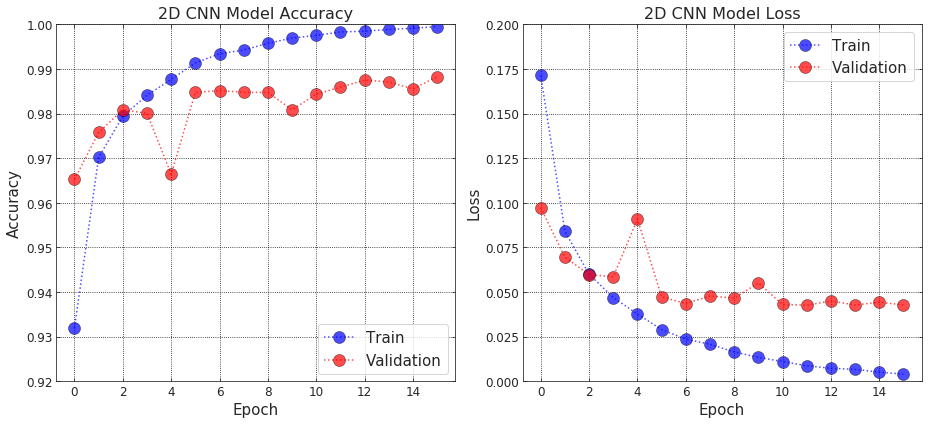

In [33]:
#model accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].plot(model_2D_log.history['binary_accuracy'], marker='o', color='blue', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[0].plot(model_2D_log.history['val_binary_accuracy'], marker='o', color='red', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.92, 1.0)
ax[0].grid(b=True, which='both', axis='both', color='k', linestyle=':')
ax[0].legend(['Train', 'Validation'], loc='lower right', prop={'size':15}, facecolor='white')
ax[0].set_title('2D CNN Model Accuracy', size=16)

ax[1].plot(model_2D_log.history['loss'], marker='o', color='blue', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[1].plot(model_2D_log.history['val_loss'], marker='o', color='red', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.0, 0.2)
ax[1].grid(b=True, which='both', axis='both', color='k', linestyle=':')
ax[1].legend(['Train', 'Validation'], loc='upper right', prop={'size':15}, facecolor='white')
ax[1].set_title('2D CNN Model Loss', size=16)

plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/2D_CNN_accloss.png')
plt.tight_layout()
plt.show()

### Conclusion: Model Comparison and Recommendation
***
The 1D CNN and 2D CNN models perform the image classification with test accuracy scores of 95.98% and 98.69% respectively. Therefore, it is recommend that the client select either one of the two CNN models. If compute resources are limited and the ability to scale is important, then the 1D CNN is recommended. If maximizing accuracy is more important, then the 2D CNN is recommended.

#### Model Accuracy

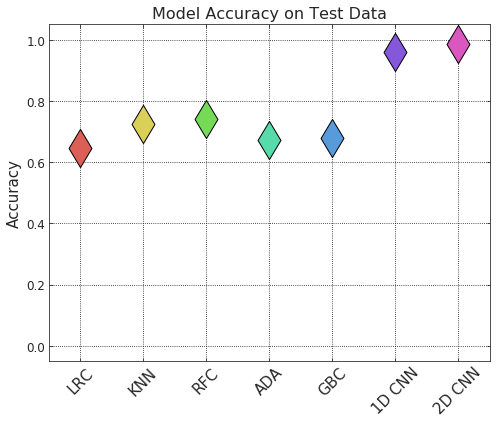

In [31]:
#model accuracy comparison on test data
names = []
accs = []
for model in accuracy:
    names.append(model)
    accs.append(accuracy[model])

fig, ax = plt.subplots(figsize=(7, 6))
sns.stripplot(names, accs, palette=sns.color_palette("hls", 7), jitter=0, marker='d', size=27, edgecolor='k', linewidth=1, ax=ax)#, markersize=20, markeredgecolor='r',markeredgewidth=0.5, linestyle='none', alpha=0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy on Test Data', size=16)
ax.grid(b=True, which='both', axis='both', color='k', linestyle=':')
plt.xticks(size=15, rotation=45)
plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/model_comp.png')

plt.tight_layout()
plt.show()

#### Receiver Operating Characteristic (ROC) & Precision-Recall curves

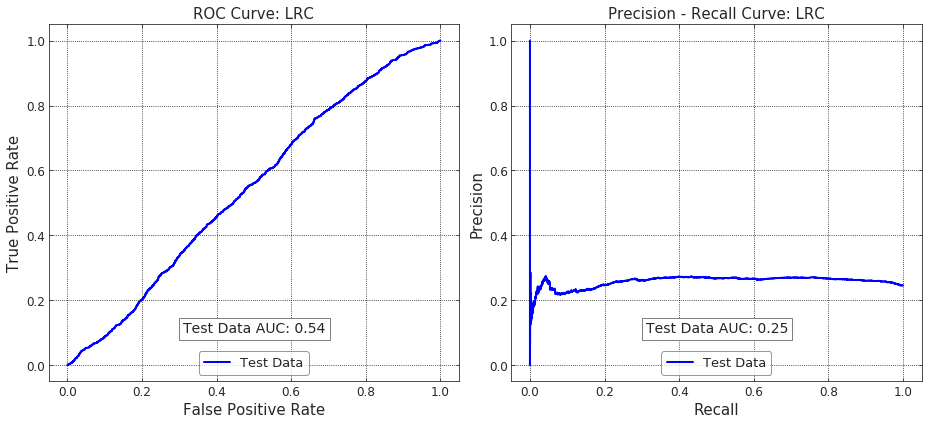

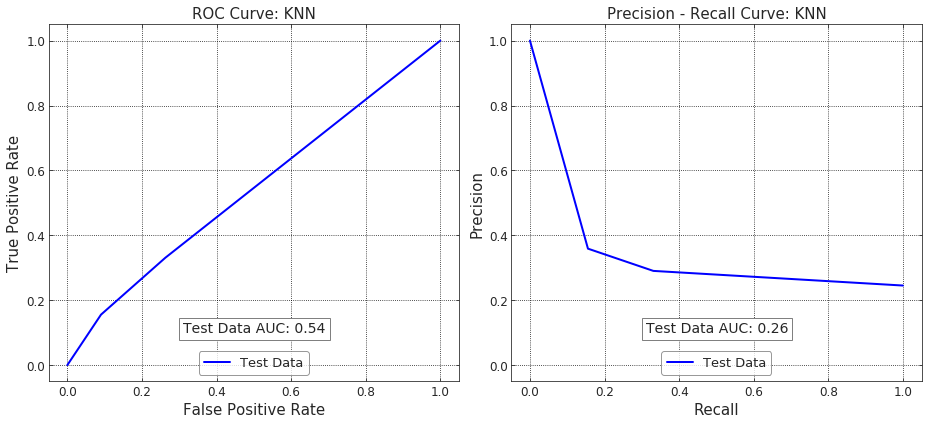

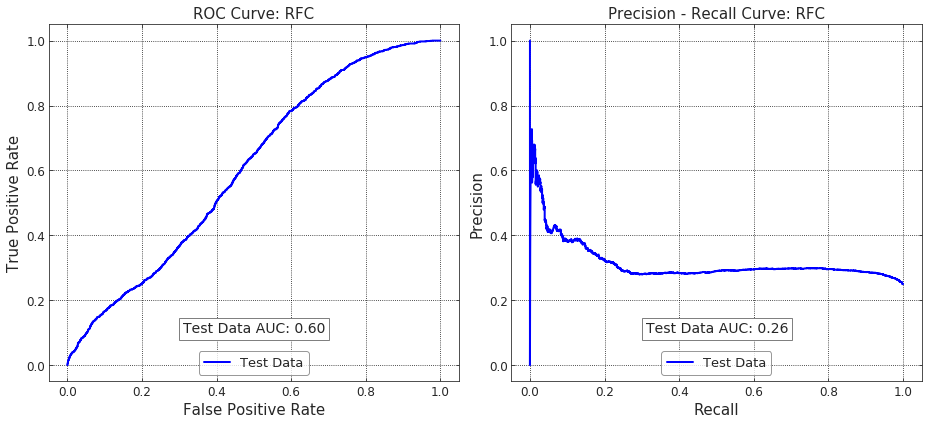

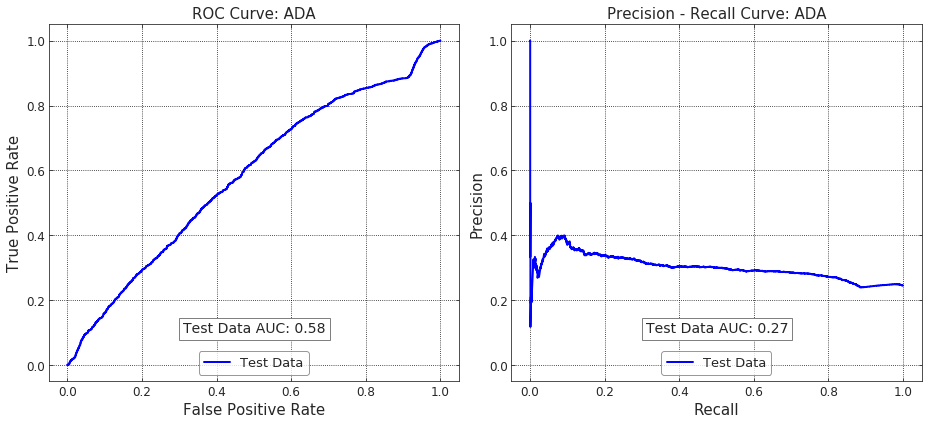

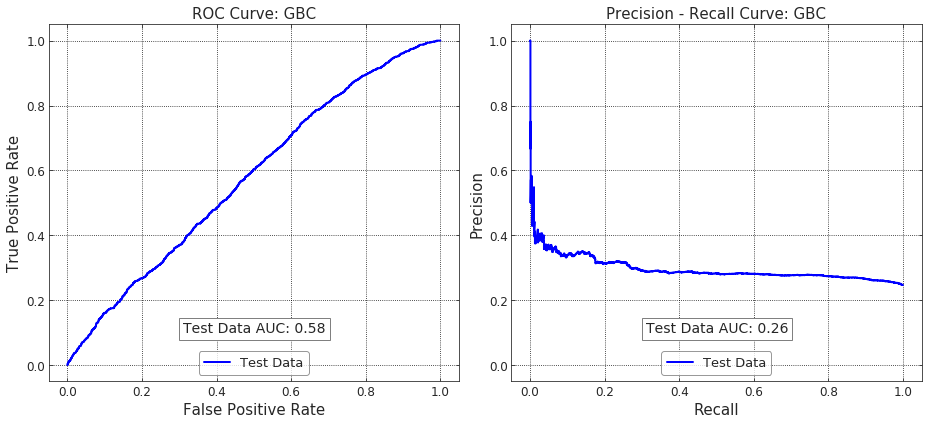

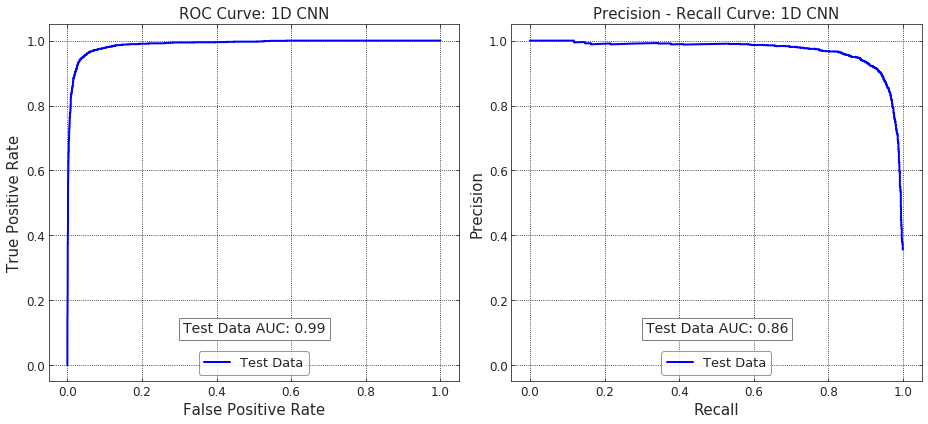

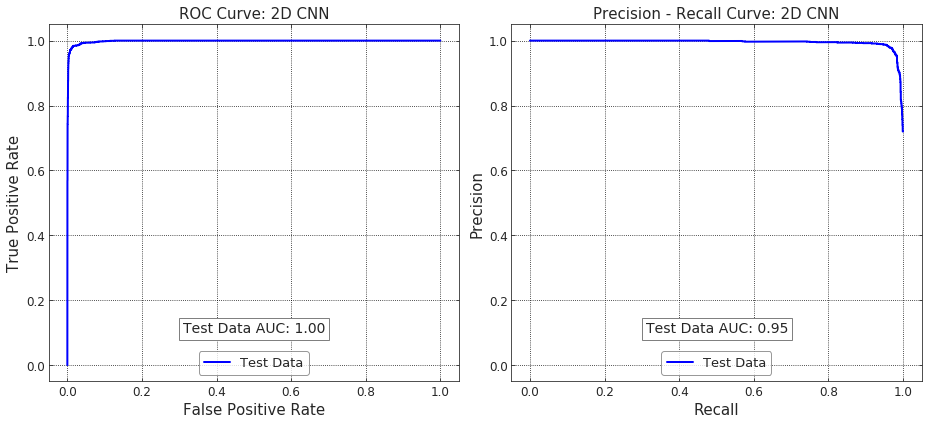

In [57]:
fit_models['1D CNN'] = model_1D
fit_models['2D CNN'] = model_2D

for model in fit_models:

    #Receiver operating characteristic (ROC)
    ypred = ypreds[model]
    if len(model) >= 4:
        ytest_pred_prob = pred_probs[model]
    else:
        ytest_pred_prob = pred_probs[model][:, 1]
        
    fpr_test, tpr_test, thresholds = metrics.roc_curve(ytest, ytest_pred_prob)
    rocauc = metrics.roc_auc_score(ytest, ytest_pred_prob)

    #plot ROC curve
    fig, ax = plt.subplots(1, 2, figsize=(13, 6))
    ax[0].plot(fpr_test, tpr_test, c='blue', linewidth=2)
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlim(-0.05, 1.05)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].grid(b=True, which='both', axis='both', color='k', linestyle=':')
    ax[0].set_title('ROC Curve: '+ str(model), size=15)
    ax[0].legend(labels=(['Test Data']), edgecolor='gray', facecolor='white', loc=8, fontsize=13)
    ax[0].text(x=0.31, y=0.10, s=('Test Data AUC: {0:.2f}'.format(rocauc)), fontsize=14, bbox=dict(edgecolor='gray', facecolor='white'))

    #precision recall
    precision_test, recall_test, thresholds = metrics.precision_recall_curve(ytest, ytest_pred_prob)
    PRauc = metrics.average_precision_score(ytest, ypred)

    #plot precision recall curve
    ax[1].plot(recall_test, precision_test, c='blue', linewidth=2)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_xlim(-0.05, 1.05)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].grid(b=True, which='both', axis='both', color='k', linestyle=':')
    ax[1].set_title('Precision - Recall Curve: ' + str(model), size=15)
    ax[1].legend(labels=(['Test Data']), edgecolor='gray', facecolor='white', loc=8, fontsize=13)
    ax[1].text(x=0.31, y=0.10, s=('Test Data AUC: {0:.2f}'.format(PRauc)), fontsize=14, bbox=dict(edgecolor='gray', facecolor='white'))
    plt.savefig('/home/delloro/Springboard/Assignments/Capstone_2/figures/ROC_PC_{}.png'.format(str(model).replace(' ', '_')))
    plt.tight_layout()
    plt.show()